## Stable Model Training (Large Batch/Limited GPU Memory Support)

## IMPORTANT: Training has -not- been verified by myself for this notebook ~jantic

### This notebook has been written to take advantage of the Large Model Support technology created by IBM.

### Information on Large Model Support
Large Model Support (LMS) is a feature provided in IBM Watson Machine Learning - Community Edition (WML-ce) PyTorch > V1.1.0 that allows the successful training of deep learning models that would otherwise exhaust GPU memory and abort with “out-of-memory” errors. LMS manages this oversubscription of GPU memory by temporarily swapping tensors to host memory when they are not needed. One or more elements of a deep learning model can lead to GPU memory exhaustion.

Requires the use of IBM WML-ce (Available here: https://www.ibm.com/support/knowledgecenter/en/SS5SF7_1.7.0/welcome/welcome.html)

Further Reading on PyTorch with Large Model Support: https://www.ibm.com/support/knowledgecenter/en/SS5SF7_1.7.0/navigation/wmlce_getstarted_pytorch.html#wmlce_getstarted_pytorch__lms_section


#### NOTE:
Using Large Model Support (LMS) will allow you to train the DeOldify models with a GPU that generally would not be suitable (e.g. GTX 1070 8Gb). A penalty to using LMS on x86_64 is that you will notice increased training times, due to the lack of a high bandwidth NVLink between the GPU and CPU.

If you are training on a PPC64LE system with NVLink (e.g. IBM AC922), then you will NOT suffer any penalty when using LMS and you can also increase the batch size to decrease the overall training times.

### Changes made

1. Larger ResNet backend (152 vs 101)
2. Easily Train on existing models (aka Tranfer Learn)
3. Easily Train via Half Precision
4. Increased Progressive Resizing to 512px
5. WIP: Train using EfficientNet backend (b7). You can optionally train to 600px if using EfficientNet

#### NOTES:  
* This is "NoGAN" based training, described in the DeOldify readme.
* This model prioritizes stable and reliable renderings.  It does particularly well on portraits and landscapes.  It's not as colorful as the artistic model.

In [19]:
#NOTE:  This must be the first call in order to work properly!
from deoldify import device
from deoldify.device_id import DeviceId
#choices:  CPU, GPU0...GPU7
device.set(device=DeviceId.GPU1)

<DeviceId.GPU1: 1>

In [2]:
# Dockerfile installs this but for some reason it's not loaded
!pip install tensorboardx==1.6.0
!pip install efficientnet-pytorch

In [3]:
resnet152_backend=False

In [4]:
import tensorflow as tf
import datetime
import os
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks.tensorboard import *
from fastai.vision.gan import *
if resnet152_backend == True:
    from deoldify.generatorsResNet152 import *
else:
    from deoldify.generators import *
# Comment out above and Uncomment below to Load EfficientNet instead of ResNet101 for generators (Work in Progress)
# from deoldify.generatorsEFFNET import *
from deoldify.critics import *
from deoldify.dataset import *
from deoldify.loss import *
from deoldify.save import *
from PIL import Image, ImageDraw, ImageFont
from PIL import ImageFile

## Setup

### Activate Large Model Support for PyTorch

In [5]:
import shutil

In [6]:
# Set limit of GPU memory used before swapping tensors to host memory. 
max_gpu_mem = 14

def gb_to_bytes(gb):
    return gb*1024*1024*1024

# Enable PyTorch LMS
torch.cuda.set_enabled_lms(True)

# Set LMS limit
torch.cuda.set_limit_lms(gb_to_bytes(max_gpu_mem))

In [7]:
# Check LMS is enabled
torch.cuda.get_enabled_lms()

# Check LMS Limit has been set
torch.cuda.get_limit_lms()

15032385536

In [20]:
# Enable Half Precision (fp16) - https://docs.fast.ai/callbacks.fp16.html
hp_enable = False

# Load existing Generator model
load_existing_gen_model = False

# Load existing Critic model
load_existing_critic_model = False

In [21]:
# Path to Training Data
path = Path('/home/yeelee/datasets/sample/train')
path_hr = path

# Path to Validation Data
path_val = '/home/yeelee/datasets/sample/val'

# Path to Black and White images
path_bandw = Path('/home/yeelee/datasets/training')
path_lr = path_bandw/'bandw'

# Name of Model
proj_id = 'ColorizeStable'

# Name of Generator
if load_existing_gen_model == False:
        gen_name = proj_id + '_gen'
else:
        # Path to existing Pre-Trained Model
        model_path = '/home/yeelee/datasets/training/bandw/models/'
        gen_name = model_path + proj_id + '_PretrainOnly_gen'

pre_gen_name = gen_name + '_0'

# Name of Critic
crit_name = proj_id + '_crit'

# Name of Generated Images folder, located within Training Data folder
name_gen = proj_id + '_image_gen'
path_gen = path/name_gen

# Path to tensorboard data
TENSORBOARD_PATH = Path('/home/yeelee/tensorboard/' + proj_id)

nf_factor = 2
pct_start = 1e-8

# Specify Pre-Trained model
gen_old_checkpoint_name = pre_gen_name


In [22]:
def get_data(bs:int, sz:int, keep_pct:float):
    return get_colorize_data(sz=sz, bs=bs, crappy_path=path_lr, good_path=path_hr, 
                             random_seed=None, keep_pct=keep_pct)

def get_crit_data(classes, bs, sz):
    src = ImageList.from_folder(path, include=classes, recurse=True).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=sz)
           .databunch(bs=bs).normalize(imagenet_stats))
    return data

def create_training_images(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn).convert('LA').convert('RGB')
    img.save(dest)  
    
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, sz=sz, keep_pct=0.085)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

## Create black and white training images

Only runs if the directory isn't already created.

In [23]:
if not path_lr.exists():
    il = ImageList.from_folder(path_hr)
    parallel(create_training_images, il.items)

In [24]:
# List total number of B&W images
total_bw = len(list(path_lr.rglob('*.*')))
print('Total B&W Images:', total_bw)

Total B&W Images: 331


## Pre-train generator

#### NOTE
Most of the training takes place here in pretraining for NoGAN.  The goal here is to take the generator as far as possible with conventional training, as that is much easier to control and obtain glitch-free results compared to GAN training.

### 64px

In [25]:
bs=160 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=64
keep_pct=1.0

In [26]:
data_gen = get_data(bs=bs, sz=sz, keep_pct=keep_pct)

In [27]:
if load_existing_gen_model == True and hp_enable == True:
        learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False).to_fp16()
elif load_existing_gen_model == True:
        learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)
elif hp_enable == True:
        learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).to_fp16()
else:
        learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor)

In [ ]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-64px'))

In [17]:
learn_gen.fit_one_cycle(40, pct_start=0.8, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,time
0,7.919384,6.826995,00:24
1,7.792355,6.795481,00:07
2,7.682005,6.773704,00:06
3,7.565657,6.755273,00:06
4,7.480027,6.735933,00:06
5,7.415862,6.714210,00:06
6,7.363877,6.701324,00:06
7,7.307184,6.682443,00:06
8,7.243916,6.646974,00:06
9,7.174023,6.597620,00:06


/home/yeelee/DeOldify/deoldify/unet.py:202: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if ssh != up_out.shape[-2:]:
/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/torch/onnx/utils.py:617: UserWarning: ONNX export failed on ATen operator mv because torch.onnx.symbolic_opset9.mv does not exist
  .format(op_name, opset_version, op_name))
Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/fastai/callback

In [18]:
learn_gen.save(pre_gen_name)

In [19]:
learn_gen.unfreeze()

In [20]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-Unfreeze-64px'))

In [21]:
learn_gen.fit_one_cycle(40, pct_start=pct_start,  max_lr=slice(3e-7, 3e-4))

epoch,train_loss,valid_loss,time
0,4.059448,3.997812,00:08
1,4.067802,4.018753,00:06
2,4.113142,3.988953,00:06
3,4.087802,3.906475,00:06
4,4.058664,3.857645,00:06
5,4.051115,3.792122,00:06
6,4.029653,3.750041,00:06
7,4.007671,3.693466,00:06
8,3.985616,3.658128,00:07
9,3.961224,3.630560,00:06


In [22]:
learn_gen.save(pre_gen_name)

### 128px

In [23]:
bs=80 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=128
keep_pct=1.0

In [24]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [25]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-128px'))

In [26]:
learn_gen.unfreeze()

In [27]:
learn_gen.fit_one_cycle(80, pct_start=pct_start, max_lr=slice(1e-7,1e-4))

epoch,train_loss,valid_loss,time
0,2.868922,2.954432,00:32
1,2.868329,2.998053,00:15
2,2.831545,3.073547,00:15
3,2.807084,2.915152,00:15
4,2.776181,2.923167,00:15
5,2.751825,2.862113,00:15
6,2.738096,2.822989,00:15
7,2.720904,2.812621,00:15
8,2.706221,2.783390,00:15
9,2.693630,2.765571,00:15


In [28]:
learn_gen.save(pre_gen_name)

### 192px

In [29]:
bs=40 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=192
keep_pct=1.0

In [30]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [31]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-192px'))

In [32]:
learn_gen.unfreeze()

In [33]:
learn_gen.fit_one_cycle(90, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

epoch,train_loss,valid_loss,time
0,2.248088,2.186725,00:50
1,2.257944,2.189981,00:30
2,2.259859,2.171449,00:30
3,2.261451,2.173212,00:30
4,2.261142,2.170906,00:31
5,2.257319,2.163649,00:30
6,2.254000,2.155539,00:29
7,2.248761,2.153423,00:29
8,2.247267,2.169370,00:30
9,2.240349,2.152013,00:30


In [34]:
learn_gen.save(pre_gen_name)

### 256px

In [ ]:
bs=20 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=256
keep_pct=1.0

In [ ]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [ ]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-256px'))

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

In [ ]:
learn_gen.save(pre_gen_name)

### 512px

In [ ]:
s=10 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=512
keep_pct=1.0

In [ ]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [ ]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-512px'))

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

In [ ]:
learn_gen.save(pre_gen_name)

### Optional if using EfficientNet backend

### 600px

In [ ]:
s=10 # This can be increased if using PyTorch LMS. Training can be slower when using x86_64. PPC64LE with NVLink (e.g. Power8 / Power9) does not suffer this training penalty
sz=600
keep_pct=1.0

In [ ]:
learn_gen.data = get_data(sz=sz, bs=bs, keep_pct=keep_pct)

In [ ]:
learn_gen.callback_fns.append(partial(ImageGenTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GenPreTrain-600px'))

In [ ]:
learn_gen.unfreeze()

In [ ]:
learn_gen.fit_one_cycle(1, pct_start=pct_start, max_lr=slice(5e-8,5e-5))

In [ ]:
learn_gen.save(pre_gen_name)

## Repeatable GAN Cycle

#### NOTE
Best results so far have been based on repeating the cycle below a few times (about 5-8?), until diminishing returns are hit (no improvement in image quality).  Each time you repeat the cycle, you want to increment that old_checkpoint_num by 1 so that new check points don't overwrite the old.  

In [42]:
old_checkpoint_num = 1
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

### Save Generated Images

In [43]:
bs=20
sz=192

In [44]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [45]:
save_gen_images()

### Pre-train the Critic on Dataset

#### Only need full pretraining of critic when starting from scratch.  Otherwise, just finetune!

In [46]:
if old_checkpoint_num == 0:
    bs=20
    sz=192
    learn_gen=None
    gc.collect()
    data_crit = get_crit_data([name_gen, 'images'], bs=bs, sz=sz)
    data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)
    learn_critic = colorize_crit_learner(data=data_crit, nf=192)
    learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPreTrain-192px'))
    learn_critic.fit_one_cycle(7, 1e-3)
    learn_critic.save(crit_old_checkpoint_name)

### Critic Training

In [47]:
bs=20
sz=192

In [48]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, sz=sz)

/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
train
  if getattr(ds, 'warn', False): warn(ds.warn)
/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
train
  if getattr(ds, 'warn', False): warn(ds.warn)


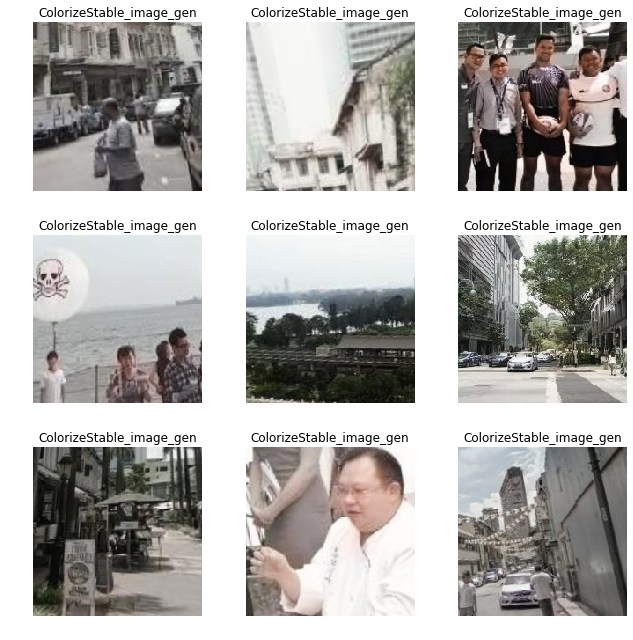

In [49]:
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [50]:
learn_critic = colorize_crit_learner(data=data_crit, nf=192).load(crit_old_checkpoint_name, with_opt=False)

In [51]:
learn_critic.callback_fns.append(partial(LearnerTensorboardWriter, base_dir=TENSORBOARD_PATH, name='CriticPreTrain-192px'))

In [52]:
learn_critic.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.001871,0.018636,1.000000,00:01
1,0.001708,0.001359,1.000000,00:01
2,0.001150,0.000118,1.000000,00:01
3,0.000855,0.000047,1.000000,00:01


In [53]:
learn_critic.save(crit_new_checkpoint_name)

### GAN

In [54]:
learn_crit=None
learn_gen=None
gc.collect()

72

In [55]:
lr=2e-5
sz=192
bs=20

In [56]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, sz=sz)

/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
train
  if getattr(ds, 'warn', False): warn(ds.warn)
/home/yeelee/miniconda3/envs/my-170-env/lib/python3.6/site-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
train
  if getattr(ds, 'warn', False): warn(ds.warn)


In [57]:
learn_crit = colorize_crit_learner(data=data_crit, nf=192).load(crit_new_checkpoint_name, with_opt=False)

In [58]:
learn_gen = gen_learner_wide(data=data_gen, gen_loss=FeatureLoss(), nf_factor=nf_factor).load(gen_old_checkpoint_name, with_opt=False)

In [59]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.0,1.5), show_img=False, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, base_dir=TENSORBOARD_PATH, name='GanLearner', visual_iters=50))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_iters=50))

#### Instructions:  
Find the checkpoint just before where glitches start to be introduced.  This is all very new so you may need to play around with just how far you go here with keep_pct.

In [61]:
learn.data = get_data(sz=sz, bs=bs, keep_pct=0.9)
learn_gen.freeze_to(-1)
learn.fit(4,lr)